In [1]:
import pandas as pd

In [2]:
# Read in cluster data
cluster_df = pd.read_csv('data/cluster_temp.csv') 

cluster_df = cluster_df.rename(columns={"id": "listing_id"})


print(cluster_df.shape)
print(cluster_df.columns)
print(cluster_df["listing_id"].nunique())

(13225, 5)
Index(['listing_id', 'host_id', 'name', 'neighbourhood_cleansed',
       'cluster_kmeans'],
      dtype='object')
13225


In [3]:
# I saved like this: results_df.to_csv(f"results_df_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv", index=False)
# Read in results_df
results_df = pd.read_csv('results_df_20251118_125309.csv')
results_df["Review"] = results_df["Review"].str.replace(r"<br\s*/?>", "", regex=True)



In [4]:
merged_df = results_df[results_df["listing_id"].isin(cluster_df["listing_id"])].merge(cluster_df, on="listing_id", how="left")
merged_df.head()

,id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,listing_id,date,reviewer_id,reviewer_name,Review,host_id,name,neighbourhood_cleansed,cluster_kmeans
0,1,0.0,0.424,0.576,0.9118,0.004214,0.090394,0.905392,7.374532e+17,2023-07-13,168460048.0,Shianne,Elizabeth was super responsive and was kind en...,64023897,Lejlighed centralt i Valby,Valby,0
1,2,0.0,0.748,0.252,0.4019,0.004356,0.229301,0.766343,7.374532e+17,2023-07-13,168460048.0,Shianne,Place matched the description and photos and w...,64023897,Lejlighed centralt i Valby,Valby,0
2,3,0.0,1.000,0.000,0.0000,0.008691,0.473369,0.517940,7.374532e+17,2023-07-13,168460048.0,Shianne,"Everything is within walking distance, especia...",64023897,Lejlighed centralt i Valby,Valby,0
3,4,0.0,0.455,0.545,0.7184,0.001651,0.021786,0.976563,7.374532e+17,2023-07-13,168460048.0,Shianne,"Enjoyed my stay, would definitely book again",64023897,Lejlighed centralt i Valby,Valby,0
4,5,0.0,0.541,0.459,0.7783,0.001498,0.010797,0.987705,2.907347e+06,2024-08-18,11387465.0,Yannis,Thanks for having us - we loved staying in the...,14853464,Nice getaway at Vesterbro,Vesterbro-Kongens Enghave,3


In [ ]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# ------------------------------------------------------
# 1. Detect probable names inside sentences
# ------------------------------------------------------
def find_probable_names(text):
    probable = set()
    sentences = re.split(r'(?<=[.!?])\s+', text)  # simple sentence split

    for sent in sentences:
        words = sent.split()
        for i, w in enumerate(words):
            # skip empty tokens
            if not w:
                continue

            # remove punctuation around token
            token = re.sub(r'^\W+|\W+$', '', w)

            # ignore empty after cleaning
            if not token:
                continue

            # rule: inside sentence AND starts uppercase AND rest lowercase
            if i > 0 and token[0].isupper() and token[1:].islower():
                probable.add(token.lower())
    return probable


# ------------------------------------------------------
# 2. Tokenizer using the rule above
# ------------------------------------------------------
def tokenize_filter_names(text, global_names):
    # split into words
    raw_tokens = re.findall(r"\b\w+\b", text)
    tokens = []

    for w in raw_tokens:
        lw = w.lower()

        # remove anything marked globally as a name
        if lw in global_names:
            continue

        tokens.append(lw)
    return tokens


# ------------------------------------------------------
# 3. Weighted contrastive word cloud
# ------------------------------------------------------
def make_weighted_wc(texts_main, texts_ref, title, ratio_threshold=1.2, min_freq=3):
    # Step A: collect all candidate names from both groups
    probable_names = set()
    for t in list(texts_main) + list(texts_ref):
        probable_names |= find_probable_names(str(t))

    # Step B: tokenize while filtering names
    main_tokens = []
    ref_tokens = []

    for t in texts_main:
        main_tokens.extend(tokenize_filter_names(str(t), probable_names))

    for t in texts_ref:
        ref_tokens.extend(tokenize_filter_names(str(t), probable_names))

    # Step C: frequency comparison
    c1 = Counter(main_tokens)
    c2 = Counter(ref_tokens)

    weights = {}
    for w, f_main in c1.items():
        if f_main < min_freq:
            continue
        f_ref = c2.get(w, 0) + 1e-6
        ratio = f_main / f_ref
        if ratio >= ratio_threshold:
            weights[w] = ratio

    if not weights:
        print(f"{title}: No distinctive words found.")
        return

    wc = WordCloud(width=800, height=400, background_color="white")
    wc.generate_from_frequencies(weights)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()



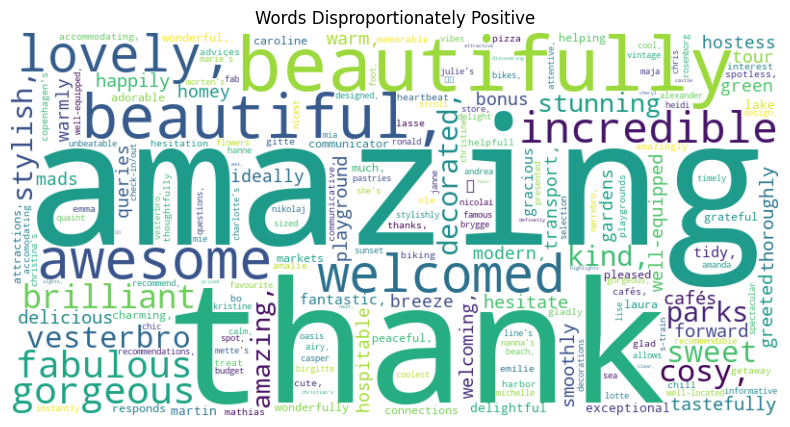

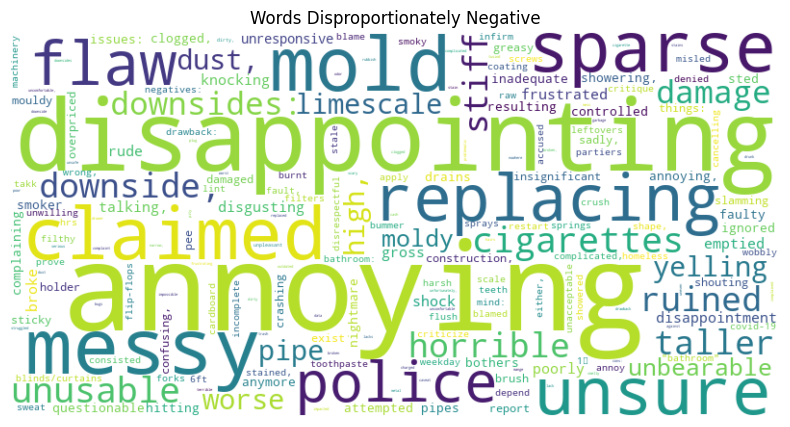

In [7]:
# Example usage
pos_texts = results_df.loc[results_df.roberta_neg < results_df.roberta_pos, "Review"]
neg_texts = results_df.loc[results_df.roberta_pos < results_df.roberta_neg, "Review"]

make_weighted_wc(pos_texts, neg_texts, "Words Disproportionately Positive")
make_weighted_wc(neg_texts, pos_texts, "Words Disproportionately Negative")

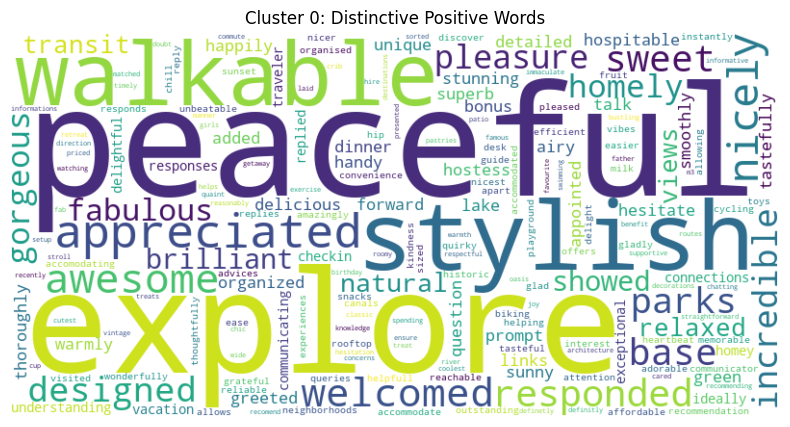

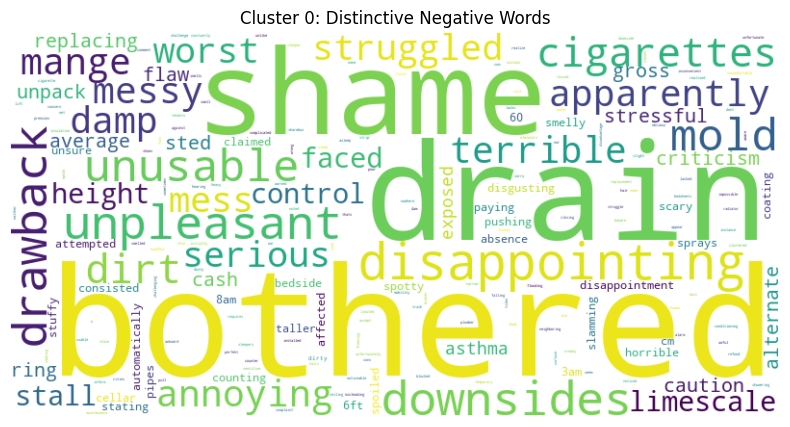

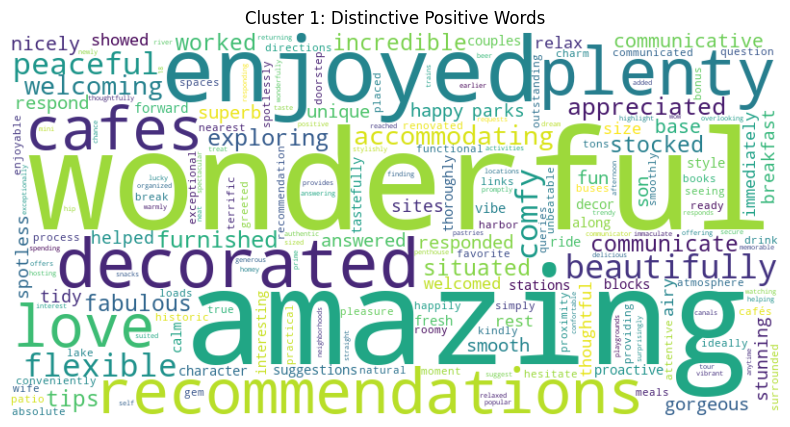

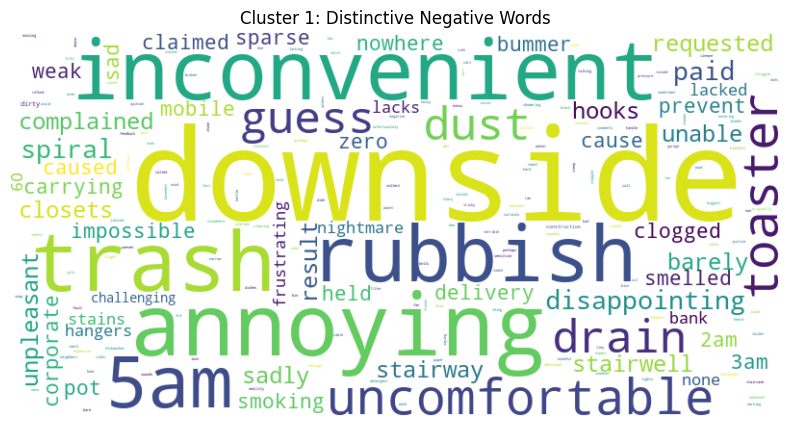

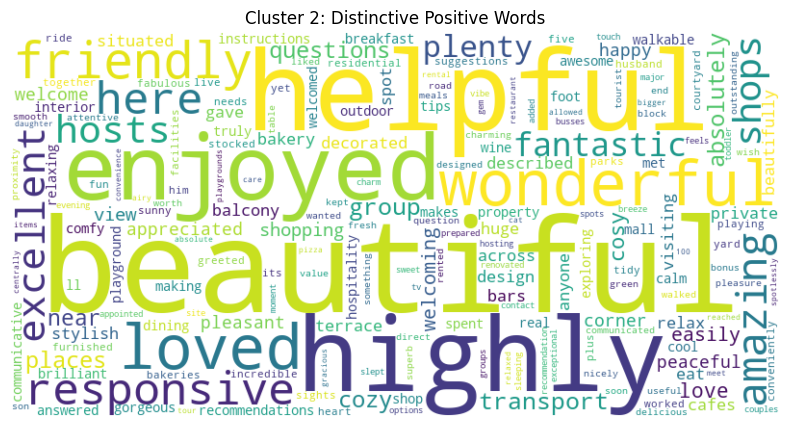

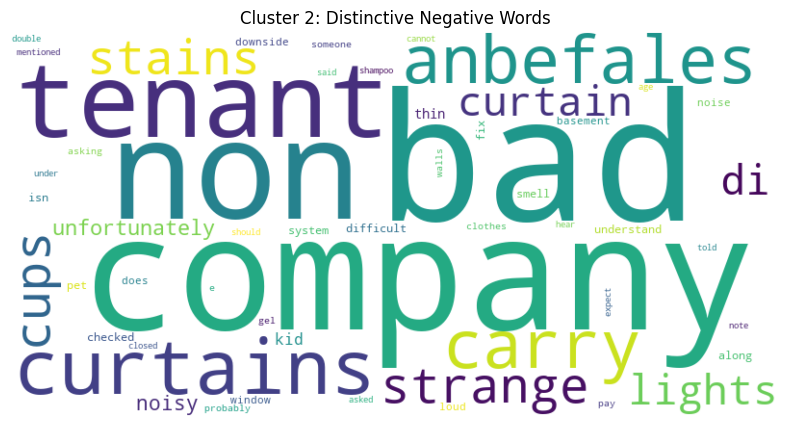

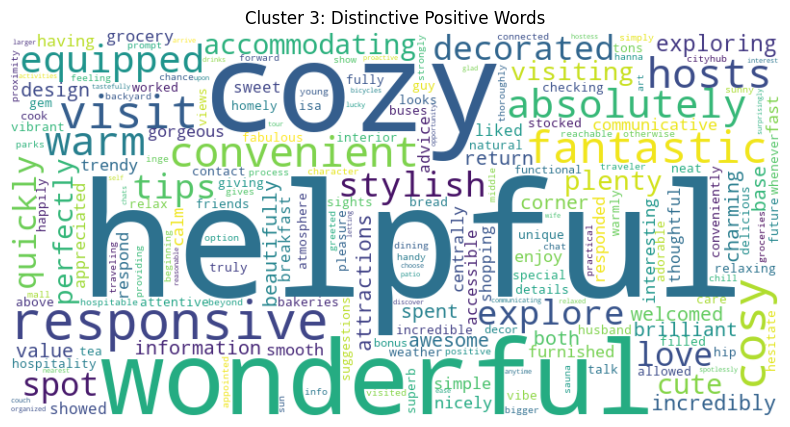

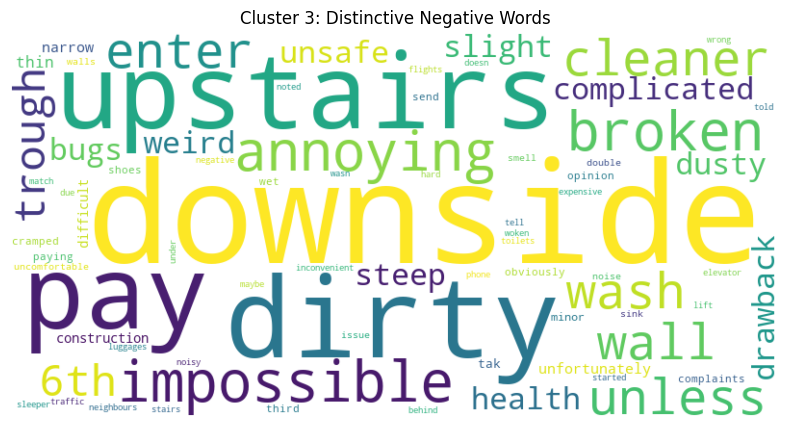

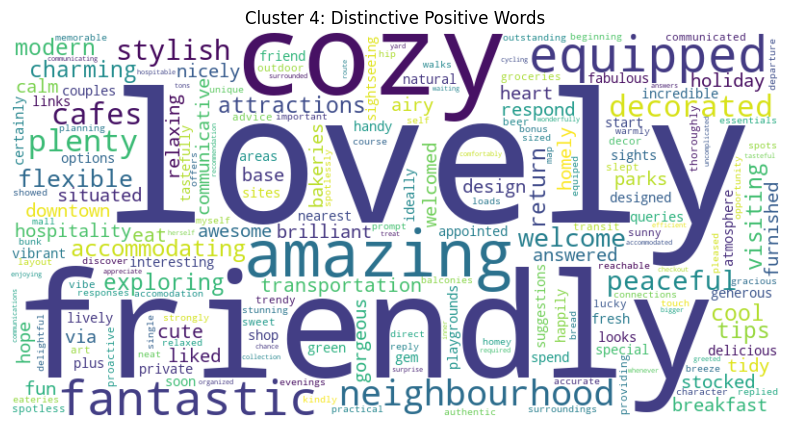

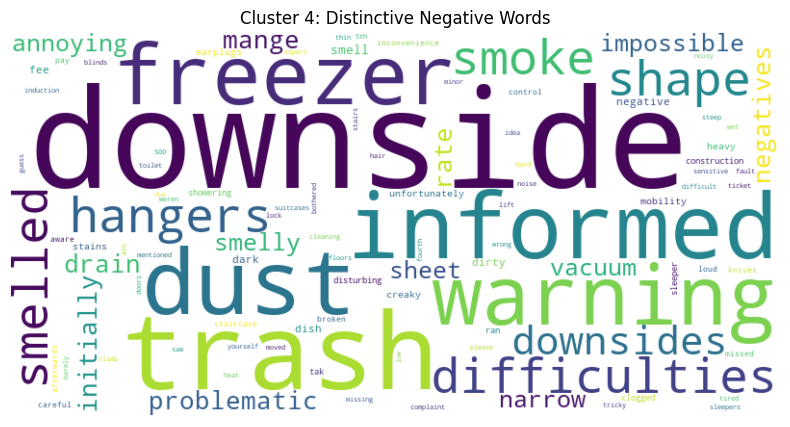

In [19]:
clusters = sorted(merged_df.cluster_kmeans.unique())
for k in clusters:

    # Positive and negative reviews inside cluster k
    pos_k = merged_df.loc[
        (merged_df.cluster_kmeans == k) &
        (merged_df.roberta_pos > merged_df.roberta_neg),
        "Review"
    ]

    neg_k = merged_df.loc[
        (merged_df.cluster_kmeans == k) &
        (merged_df.roberta_neg > merged_df.roberta_pos),
        "Review"
    ]

    # Compare positive vs negative within the cluster
    make_weighted_wc(
        pos_k, 
        neg_k, 
        f"Cluster {k}: Distinctive Positive Words"
    )

    make_weighted_wc(
        neg_k, 
        pos_k, 
        f"Cluster {k}: Distinctive Negative Words"
    )
